In [1]:
from pathlib import Path
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
import seaborn as sns

import trompy as tp

from collections import defaultdict

from scipy import stats
import statsmodels.api as sm

colors_PVH = "#219C90"
colors_VMH  = "#90219c"

colors = [colors_PVH, colors_VMH]

cmap = "RdBu_r"

In [27]:
DATAFOLDER = Path("C:/Data/hislight_pickles/")
FIGSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper/figures")
STATSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper")

with open(DATAFOLDER / "restricted_dark.pickle", 'rb') as handle:
    PVH_restricted_dark = pickle.load(handle)

with open(DATAFOLDER / "adlib_dark.pickle", 'rb') as handle:
    PVH_adlib_dark = pickle.load(handle)

with open(DATAFOLDER / "adlib_light.pickle", 'rb') as handle:
    PVH_adlib_light = pickle.load(handle)

with open(DATAFOLDER / "adlib_sucralose.pickle", 'rb') as handle:
    PVH_adlib_sucralose = pickle.load(handle)
    
    

with open(DATAFOLDER / "HL3_restricted_dark.pickle", 'rb') as handle:
    VMH_restricted_dark = pickle.load(handle)

with open(DATAFOLDER / "HL3_adlib_dark.pickle", 'rb') as handle:
    VMH_adlib_dark = pickle.load(handle)

with open(DATAFOLDER / "HL3_adlib_light.pickle", 'rb') as handle:
    VMH_adlib_light = pickle.load(handle)

with open(DATAFOLDER / "HL3_adlib_sucralose.pickle", 'rb') as handle:
    VMH_adlib_sucralose = pickle.load(handle) 

In [3]:
PVH_list_of_mice = []
VMH_list_of_mice = []

mice_to_exclude = ["HL313", "HL314", "HL315", "HL316", "HL317", "HL318", "HL306", "HL308",
                    "HL202", "HL205", "HL206", "HL211",
                    "HL301", "HL304", "HL305"]

#"HL202", "HL205", "HL206", "HL211" have poor placements without virus in PVH
#HL 306, 308 have no virus
#HL301, HL304, HL305 have poor fiber placement
#HL313 - HL318 are control mice


for key, val in PVH_restricted_dark.items():
    if val["mouse_ID"] not in mice_to_exclude:
        if val["mouse_ID"] not in PVH_list_of_mice:
            PVH_list_of_mice.append(val["mouse_ID"])
        
for key, val in VMH_restricted_dark.items():
    if val["mouse_ID"] not in mice_to_exclude:
        if val["mouse_ID"] not in VMH_list_of_mice:
            VMH_list_of_mice.append(val["mouse_ID"])

In [4]:
def get_aucs(data, mouse):
    
    pre = 5
    post = 10
    mineventlength = 8
    binlength = 0.1

    snips_full = []
    run_lengths = []

    for key, val in data.items():
        if val["mouse_ID"] == mouse:
            if len(val["licks"]) < 10:
                continue

            lickdata = tp.lickCalc(val["licks"], minrunlength=3)

            snipper = tp.Snipper(val["corrected"],
                                 lickdata["rStart"],
                                 end=lickdata["rEnd"],
                                 fs=val["fs"],
                                 pre=pre,
                                 post=post,
                                 binlength=binlength,
                                 zscore=True
                                 )
            
            snipper.truncate_to_same_length(cols_to_add=10, mineventlength=8, eventbalance=[6,2])
            snipper.find_potential_artifacts(threshold=12, method="absolute_diff", showplot=True, remove=True)
            plt.plot(snipper.snips.T, color="black", alpha=0.1)
            snips_full.append(snipper.snips)
            
            print(snipper.snips.shape)
            
            run_lengths_temp = (np.array(lickdata["rEnd"]) - np.array(lickdata["rStart"]))
            run_lengths.append(run_lengths_temp[run_lengths_temp > mineventlength])
        
    try:
        snips_full = np.vstack(snips_full)
        print("adding this mouse")
    except:
        print("no snips to concatenate")
        
    run_lengths = tp.flatten_list(run_lengths)

    # Normalizing AUC calculations to epoch length
    auc_early_licking = np.trapz(snips_full[:, 50:110], axis=1) / 60 #60 because 6 seconds
    auc_late_licking = np.trapz(snips_full[:, 120:140], axis=1) / 20  #2 seconds
    auc_early_post_licking = np.trapz(snips_full[:, 140:190], axis=1) / 50 # 5 seconds
    auc_late_post_licking = np.trapz(snips_full[:, 190:240], axis=1) / 50 # 5 seconds
    
    return snips_full, pd.DataFrame([run_lengths,
                                    auc_early_licking,
                                    auc_late_licking,
                                    auc_early_post_licking,
                                    auc_late_post_licking],
                                    
                                    index=["run_lengths", "auc_early_licking", "auc_late_licking", "auc_early_post_licking", "auc_late_post_licking"]).T
    

In [5]:
def plot_scatter_and_line_of_best_fit(x, y, ax, color, alpha=0.1, label=None):
    # Scatter plot with the color for each mouse
    ax.scatter(x, y, color=color, alpha=alpha, label=label)

    # Fit the model using OLS from statsmodels
    X = sm.add_constant(x)  # Add constant term for intercept
    model = sm.OLS(y, X).fit()  # Fit the model
    slope = model.params[1]  # Get slope
    intercept = model.params[0]  # Get intercept

    # Compute the line of best fit
    xrange = np.linspace(10, ax.get_xlim()[1], 100)
    line = slope * xrange + intercept

    # Plot the line of best fit with a dashed line
    ax.plot(xrange, line, color=color, linestyle='--', linewidth=1)

    # Calculate p-value for the slope
    p_value = model.pvalues[1]  # p-value for slope

    return slope, intercept, p_value  # Return slope, intercept, and p-value

def plot_mean_line_from_slopes(xrange, mean_slope, mean_intercept, ax, color='black'):
    """Plots a line of best fit using the mean slope and intercept."""
    mean_line = mean_slope * xrange + mean_intercept
    ax.plot(xrange, mean_line, color=color, linestyle='-', linewidth=2, label='Mean Line')


<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(5, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(7, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(6, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(14, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(18, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(11, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(13, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(12, 240)


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(11, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(15, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(17, 240)
<class 'numpy.ndarray'>
Found 2 potential artifacts.
(13, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(13, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(11, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(17, 240)
adding this mouse
<class 'numpy.ndarray'>


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
(16, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(11, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(12, 240)
adding this mouse
<class 'numpy.ndarray'>


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
(11, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(8, 240)
<class 'numpy.ndarray'>
Found 1 potential artifacts.
(7, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(4, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(4, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(5, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(4, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(4, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(10, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(4, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(9, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(6, 240)
addi

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(2, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(4, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(3, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(1, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(6, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(3, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(4, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(3, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(6, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(4, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(5, 240)
adding this mouse
<class '

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


(6, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(12, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(9, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(7, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(8, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(6, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(5, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(3, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(2, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(2, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(3, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artif

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

ZeroDivisionError: integer division or modulo by zero

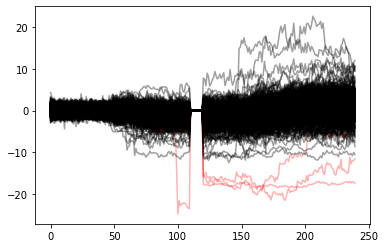

In [17]:
pvh_restricted_data = {}
for mouse in PVH_list_of_mice:
    snips, pvh_restricted_data[mouse] = get_aucs(PVH_restricted_dark, mouse)
    
pvh_light_data = {}
for mouse in PVH_list_of_mice:
    snips, pvh_light_data[mouse] = get_aucs(PVH_adlib_light, mouse)
    
pvh_dark_data = {}
for mouse in PVH_list_of_mice:
    snips, pvh_dark_data[mouse] = get_aucs(PVH_adlib_dark, mouse)
    
pvh_sucralose_data = {}
for mouse in PVH_list_of_mice:
    snips, pvh_sucralose_data[mouse] = get_aucs(PVH_adlib_sucralose, mouse)


In [ ]:
def filter_aucs(data):
    
    filtered_dictionary = {}
    
    for mouse_id, auc_data in data.items():
        # Calculate the standard deviation for each AUC metric
        early_threshold = np.std(auc_data['auc_early_licking']) * 3
        late_threshold = np.std(auc_data['auc_late_licking']) * 3
        early_post_threshold = np.std(auc_data['auc_early_post_licking']) * 3
        late_post_threshold = np.std(auc_data['auc_late_post_licking']) * 3

        # Define query strings for filtering each column based on the thresholds
        early_qs = f"auc_early_licking < {early_threshold} and auc_early_licking > {-early_threshold}"
        late_qs = f"auc_late_licking < {late_threshold} and auc_late_licking > {-late_threshold}"
        early_post_qs = f"auc_early_post_licking < {early_post_threshold} and auc_early_post_licking > {-early_post_threshold}"
        late_post_qs = f"auc_late_post_licking < {late_post_threshold} and auc_late_post_licking > {-late_post_threshold}"

        # Combine the query strings to create a single filter
        query_string = f"{early_qs} and {late_qs} and {early_post_qs} and {late_post_qs}"

        # Filter the mouse data based on the combined query string
        filtered_auc_data = auc_data.query(query_string)

        # Add the filtered data to the new dictionary
        filtered_dictionary[mouse_id] = filtered_auc_data
        
    return filtered_dictionary    

In [39]:
def analyze_and_plot_data(filtered_data, condition_name):
    print(f"{condition_name} analysis")

    f, ax = plt.subplots(nrows=4, figsize=(2, 8), sharex=True,
                         gridspec_kw={"hspace": 0.1, "wspace": 0.1,
                                      "left": 0.02,
                                      "right": 0.98,
                                      "top": 0.98,
                                      "bottom": 0.02})

    # Colors for each mouse
    #colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']
    colors = ['teal', 'yellow', 'gold', 'turquoise', 'magenta', 'coral', 'slategray']

    # Data for storing slopes, intercepts, and p-values
    slopes_early_licking = []
    intercepts_early_licking = []
    p_values_early_licking = []
    slopes_late_licking = []
    intercepts_late_licking = []
    p_values_late_licking = []
    slopes_early_post_licking = []
    intercepts_early_post_licking = []
    p_values_early_post_licking = []
    slopes_late_post_licking = []
    intercepts_late_post_licking = []
    p_values_late_post_licking = []

    # Iterate over the filtered data for each mouse  
    for i, (mouse_id, auc_data) in enumerate(filtered_data.items()):
        color = colors[i % len(colors)]

        # Plot and collect slopes/intercepts and p-values for each metric
        slope, intercept, p_value = plot_scatter_and_line_of_best_fit(
            auc_data.run_lengths,
            auc_data.auc_early_licking,
            ax[0],
            color,
            label=mouse_id
        )
        slopes_early_licking.append(slope)
        intercepts_early_licking.append(intercept)
        p_values_early_licking.append(p_value)

        slope, intercept, p_value = plot_scatter_and_line_of_best_fit(
            auc_data.run_lengths,
            auc_data.auc_late_licking,
            ax[1],
            color,
            label=mouse_id
        )
        slopes_late_licking.append(slope)
        intercepts_late_licking.append(intercept)
        p_values_late_licking.append(p_value)

        slope, intercept, p_value = plot_scatter_and_line_of_best_fit(
            auc_data.run_lengths,
            auc_data.auc_early_post_licking,
            ax[2],
            color,
            label=mouse_id
        )
        slopes_early_post_licking.append(slope)
        intercepts_early_post_licking.append(intercept)
        p_values_early_post_licking.append(p_value)

        slope, intercept, p_value = plot_scatter_and_line_of_best_fit(
            auc_data.run_lengths,
            auc_data.auc_late_post_licking,
            ax[3],
            color,
            label=mouse_id
        )
        slopes_late_post_licking.append(slope)
        intercepts_late_post_licking.append(intercept)
        p_values_late_post_licking.append(p_value)

    # Compute mean slope and intercept for each metric
    mean_slope_early_licking = np.mean(slopes_early_licking)
    mean_intercept_early_licking = np.mean(intercepts_early_licking)

    mean_slope_late_licking = np.mean(slopes_late_licking)
    mean_intercept_late_licking = np.mean(intercepts_late_licking)

    mean_slope_early_post_licking = np.mean(slopes_early_post_licking)
    mean_intercept_early_post_licking = np.mean(intercepts_early_post_licking)

    mean_slope_late_post_licking = np.mean(slopes_late_post_licking)
    mean_intercept_late_post_licking = np.mean(intercepts_late_post_licking)

    # Print p-values for each slope
    print("P-values for slopes:")
    print(f"Early AUC vs. Run Length: {p_values_early_licking}")
    print(f"Late AUC vs. Run Length: {p_values_late_licking}")
    print(f"Early Post AUC vs. Run Length: {p_values_early_post_licking}")
    print(f"Late Post AUC vs. Run Length: {p_values_late_post_licking}")

    # One-sample t-test to check if the mean slope is significantly different from zero
    t_stat_early_licking, p_val_early_licking = stats.ttest_1samp(slopes_early_licking, 0)
    t_stat_late_licking, p_val_late_licking = stats.ttest_1samp(slopes_late_licking, 0)
    t_stat_early_post_licking, p_val_early_post_licking = stats.ttest_1samp(slopes_early_post_licking, 0)
    t_stat_late_post_licking, p_val_late_post_licking = stats.ttest_1samp(slopes_late_post_licking, 0)

    # Print the results of the one-sample t-tests
    print("\nOne-sample t-test results:")
    print(f"Early Licking: t-statistic = {t_stat_early_licking}, p-value = {p_val_early_licking}")
    print(f"Late Licking: t-statistic = {t_stat_late_licking}, p-value = {p_val_late_licking}")
    print(f"Early Post Licking: t-statistic = {t_stat_early_post_licking}, p-value = {p_val_early_post_licking}")
    print(f"Late Post Licking: t-statistic = {t_stat_late_post_licking}, p-value = {p_val_late_post_licking}")

    # Define the shared x-range for the mean lines
    xrange = np.linspace(10, ax[0].get_xlim()[1], 100)

    # Plot the mean lines for each metric
    plot_mean_line_from_slopes(xrange, mean_slope_early_licking, mean_intercept_early_licking, ax[0], color='black')
    plot_mean_line_from_slopes(xrange, mean_slope_late_licking, mean_intercept_late_licking, ax[1], color='black')
    plot_mean_line_from_slopes(xrange, mean_slope_early_post_licking, mean_intercept_early_post_licking, ax[2], color='black')
    plot_mean_line_from_slopes(xrange, mean_slope_late_post_licking, mean_intercept_late_post_licking, ax[3], color='black')

    # Customize the appearance of each axis
    for axis in ax:
        axis.axhline(0, linestyle="--", color="black", alpha=0.5)
        axis.set_xscale("log")
        axis.set_ylim(-8, 8)
        axis.set_yticklabels([])
        axis.set_xlim(4, 300)
        axis.set_xticks([10, 100, 200, 300])
        axis.set_xticklabels([])

        axis.spines["top"].set_visible(False)
        axis.spines["right"].set_visible(False)

    plt.show()
    return f


In [18]:
filtered_pvh_restricted_data = filter_aucs(pvh_restricted_data)
filtered_pvh_light_data = filter_aucs(pvh_light_data)
filtered_pvh_dark_data = filter_aucs(pvh_dark_data)
filtered_pvh_sucralose_data = filter_aucs(pvh_sucralose_data)

<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(15, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(13, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(9, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(5, 240)
<class 'numpy.ndarray'>
Found 1 potential artifacts.
(13, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

(13, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(14, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(13, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(12, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(5, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(8, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(6, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(9, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(8, 240)
<class 'numpy.ndarray'>


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 0 potential artifacts.
No artifacts found.
(18, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(16, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(11, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(16, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(10, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(13, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(11, 240)
adding this mouse
<class 'numpy.ndarray'>

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


Found 0 potential artifacts.
No artifacts found.
(2, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(2, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(6, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(4, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(9, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(6, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(1, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(1, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(3, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(1, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(1, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifac

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di


Found 0 potential artifacts.
No artifacts found.
(2, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(10, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(9, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(11, 240)
<class 'numpy.ndarray'>
Found 1 potential artifacts.
(11, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(5, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(6, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(6, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(4, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(12, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(12, 240)
adding this mouse
<class 'numpy.ndarray'>


C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

Found 1 potential artifacts.
(10, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(8, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(7, 240)
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(6, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 1 potential artifacts.
(5, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(4, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(2, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(3, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(6, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(1, 240)
adding this mouse
<class 'numpy.ndarray'>
Found 0 potential artifacts.
No artifacts found.
(1, 240)
adding this mouse

C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array([self.put_snip_in_bins(snip) for snip in self.snips])
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:229: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.snips = np.array(z_snips)
C:\Users\kvo019\Anaconda3\lib\site-packages\trompy\snipper_class.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

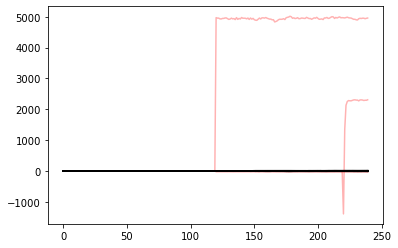

In [35]:
vmh_restricted_data = {}
for mouse in VMH_list_of_mice:
    snips, vmh_restricted_data[mouse] = get_aucs(VMH_restricted_dark, mouse)
    
vmh_light_data = {}
for mouse in VMH_list_of_mice:
    snips, vmh_light_data[mouse] = get_aucs(VMH_adlib_light, mouse)
    
vmh_dark_data = {}
for mouse in VMH_list_of_mice:
    snips, vmh_dark_data[mouse] = get_aucs(VMH_adlib_dark, mouse)
    
vmh_sucralose_data = {}
for mouse in VMH_list_of_mice:
    snips, vmh_sucralose_data[mouse] = get_aucs(VMH_adlib_sucralose, mouse)

In [36]:
filtered_vmh_restricted_data = filter_aucs(vmh_restricted_data)
filtered_vmh_light_data = filter_aucs(vmh_light_data)
filtered_vmh_dark_data = filter_aucs(vmh_dark_data)
filtered_vmh_sucralose_data = filter_aucs(vmh_sucralose_data)

In [37]:
# PUTTING ALL CONDITIONS TOGETHER FOR EACH MOUSE, VMH

# Initialize a defaultdict to hold merged DataFrames
merged_dict = defaultdict(list)

# List of dictionaries to merge
dicts_to_merge = [filtered_vmh_restricted_data, filtered_vmh_light_data, filtered_vmh_dark_data, filtered_vmh_sucralose_data]

# Iterate through each dictionary
for d in dicts_to_merge:
    for key, df in d.items():
        if not df.empty:  # Ensure the DataFrame is not empty
            merged_dict[key].append(df)  # Append the DataFrame to the list for the key

# Now merge the DataFrames for each mouse into one DataFrame
VMH_final_merged_dict = {}
for key, df_list in merged_dict.items():
    VMH_final_merged_dict[key] = pd.concat(df_list, ignore_index=True)  # Concatenate the list of DataFrames

# Print the final merged dictionary
#for mouse, data in VMH_final_merged_dict.items():
#    print(f"{mouse}:\n{data}\n")


VMH all conditions analysis
P-values for slopes:
Early AUC vs. Run Length: [0.6789130741837756, 0.6036585771975927, 0.45411703991260743, 0.09552344183090855, 0.557063069675949, 0.9419524194075161, 0.3157661191243077]
Late AUC vs. Run Length: [0.037911655462589844, 0.15844508713408537, 0.11419240964651026, 0.0011210239943572897, 0.0066383589092544335, 0.40975923421050486, 0.29743117582156287]
Early Post AUC vs. Run Length: [0.02117950926585695, 0.15670034007249195, 0.317400226322525, 0.010510548962247799, 0.04464179703147538, 0.44351330235932374, 0.5509555686070451]
Late Post AUC vs. Run Length: [0.13987929335863422, 0.11353153314503113, 0.27524487665249564, 0.01929959004574496, 0.03634970024054847, 0.0354043046343822, 0.7787027318537]

One-sample t-test results:
Early Licking: t-statistic = -0.46579925852495796, p-value = 0.6577880435223359
Late Licking: t-statistic = -4.75068264051142, p-value = 0.0031565007556309172
Early Post Licking: t-statistic = -3.7890614232127, p-value = 0.0090

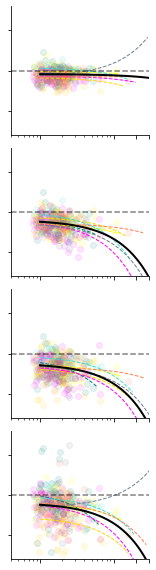

In [40]:
f = analyze_and_plot_data(VMH_final_merged_dict, "VMH all conditions")

f.savefig(FIGSFOLDER / "VMH_correlations.pdf")

In [24]:
# PUTTING ALL CONDITIONS TOGETHER FOR EACH MOUSE, PVH

merged_dict = defaultdict(list)


dicts_to_merge = [filtered_pvh_restricted_data, filtered_pvh_light_data, filtered_pvh_dark_data, filtered_pvh_sucralose_data]

for d in dicts_to_merge:
    for key, df in d.items():
        if not df.empty:  
            merged_dict[key].append(df) 

PVH_final_merged_dict = {}
for key, df_list in merged_dict.items():
    PVH_final_merged_dict[key] = pd.concat(df_list, ignore_index=True)


PVH all conditions analysis
P-values for slopes:
Early AUC vs. Run Length: [0.2979402963236969, 0.0014376995358968325, 0.8448480714686147, 0.6927355715804451, 0.06425973223797452, 0.25415796606837715, 0.06369132965081278]
Late AUC vs. Run Length: [0.05975396440530125, 0.11091093318608256, 0.004568719024436885, 0.02947392794104652, 0.1411708320135499, 0.7182399346933798, 0.7500036775473201]
Early Post AUC vs. Run Length: [0.012678797590299794, 0.38110259410059844, 0.0013743516063265794, 0.24427804580781703, 0.8770833023758512, 0.3945688317834726, 0.5168262081480797]
Late Post AUC vs. Run Length: [0.06903725792004817, 0.7882400127870224, 1.7959607771769675e-05, 0.5886238300195488, 0.6755479008861143, 0.08031872181537185, 0.49907230953479575]

One-sample t-test results:
Early Licking: t-statistic = -0.559160996674469, p-value = 0.5962895997506497
Late Licking: t-statistic = -0.3646555646166875, p-value = 0.727876109395285
Early Post Licking: t-statistic = -1.3675377459021756, p-value = 0.

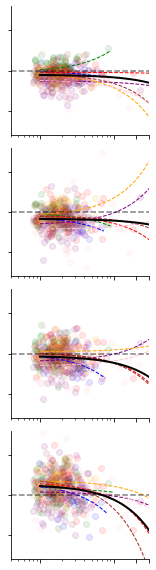

In [32]:
f =analyze_and_plot_data(PVH_final_merged_dict, "PVH all conditions")

f.savefig(FIGSFOLDER / "PVH_correlations.pdf")